<a href="https://colab.research.google.com/github/dqniellew1/DLPT/blob/master/Using_convolutions_to_generalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
drive_dir = 'drive/My Drive/dlwpt-code/data/'

Taking a 1D view of our input image and multiplying it with a `n_output_features x n_input_features` weight matrix, as done in `nn.Linear`, means taking all pixels in the image, and for each channel computing a weighted sum of all pixels multiplied by a set of weights, one per output feature.

In [2]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets, transforms

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
                           transform=transforms.Compose([
                                                         transforms.ToTensor(),
                                                         transforms.Normalize(
                                                             (0.4915, 0.4823, 0.4468),
                                                             (0.2470, 0.2435, 0.2616))
                                                         ]))

Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [107]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
                               transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                   (0.2470, 0.2435, 0.2616))
                              ]))

Files already downloaded and verified


In [6]:
label_map = {0:1, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

# Convolutions

`nn.Conv1d` for time series, `nn.Conv2d` for images and `nn.Conv3d` for volumes or videos.

The arguments we provide to `nn.Conv2d` are the:
1. The number of input features (or channels, since we are dealing with so-called multi-channel images, i.e. more than one value per pixel)
2. The number of output features (arbitrary number, the more channels in the output image, the more the capacity of the network)
3. The size of the kernel


In [7]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

We expect the weight tensor to be sized `n_input_channels x 3 x 3 x n_output_channels`. The bias is just a constant value we add to each channel of the output image.

\* weights are initialized randomly

**As usual we need to add the zero-th batch dimension with unsqueeze** if we want to call the `conv` module with one input image. `nn.Conv2d` expects `B x C x H x W`.

In [8]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

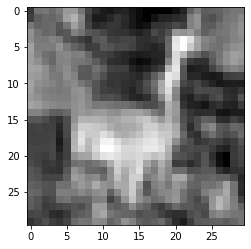

In [10]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()
# Bird after a random convolution treatment

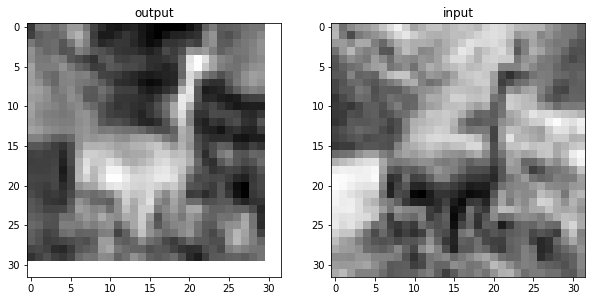

In [11]:
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title("output")
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray')
plt.title("input")
plt.show()

The output size is slightly less because it is a side effect of deciding what to do at the boundary of the image.

To preserve image size, PyTorch gives us the possibility of padding the image, creating ghost pixels around the border that value zero as far as the convolution is concerned.

Specifying `padding=1` when `kernel_size=3` means that now `i00` has an extra set of neighbours above and left, so that an output of the convolution can be computed even in the corner of our original image.

In [ ]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

\* the size of `weight` and `bias` dont change whether padding is used or not.

In [ ]:
# play with convolution setting; weights by hand
with torch.no_grad():
  conv.bias.zero_() # zero out bias to remove any confounding factor

with torch.no_grad():
  conv.weight.fill_(1.0 / 9.0)

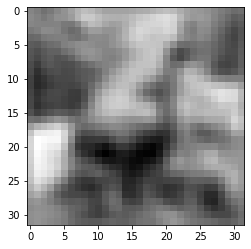

In [ ]:
# See the results in the output image
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()
# bird, this time blurred thanks to a constant convolution kernel.

Every pixel of the output is the average of a neighborhood of the input, so output pixels of the output will be correlated and change more smoothly.

In [ ]:
# We can try something different
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
  conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
  conv.bias.zero_()

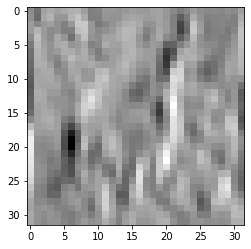

In [ ]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()
# Vertical edges throughout our bird because of hand-crafted kernel

## Depth and pooling

If we wish to downsample our image by half, we'll want to use a size of 2.

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Proceed to building our convolutional neural network for detecting birds and planes.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
)

Gone from 3 RGB channels to 16, thereby giving the network a chance to generate 16 independent features that will operate to hopefully discriminate low-level features of birds and airplanes. 

After the activation is applied, the 16-channel 32x32 image will be pooled to a 16-channel 16x16 image. 

At this point, the downsampled image will undergo another convolution that will generate a 8-channel 16x16 output, which again after the activation, will be pooled to a 8-channel 8x8 output.

After the input image has been reduced to a set of 8x8 features, we expect some output of probabilities, so that we can feed our negative log likelihood. 

However, probabilities are a pair of numbers in a 1D vector (1 for bird, 1 for airplane, while we are still dealing with multi-channel 2D features.

In [ ]:
# Turn our 8-channel 8x8 image into a 1D vector 
# Complete our network with a set of fully connected layers.
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ... Missing something important?
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2))
# Linear layer is dependent on the expected size of the MaxPool2d output
# i.e. 8 * 8 * 8 = 512

In [ ]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Reasonable! In order to increase the capacity of the model, we could
1. increase the number of output channels for the conv layers (which would lead to the linear layer increasing in size as well)

In [ ]:
model(img.unsqueeze(0))

RuntimeError: ignored

What is missing there is the **reshaping step** from a 8-channel 8x8 image to a 512-element, 1D vector.

We could use `view` on the output of the last `nn.MaxPool2d` but we dont have visibility of output of each module when we use `nn.Sequential`.

# Subclassing nn.Module

we need some flexibility therefore we need to subclass. In order to subclass, at the minimum we need to define the `forward` function

In [12]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = self.view(-1, 8 * 8 * 8) # The reshape. we have been missing
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

This `Net` class is equivalent to the `nn.Sequential` model we build in terms of submodules, by writing the `forward` function explicitly, we were able to manipulate the output of `self.pool3` directly and call `view` om it to turn it into a BxN vector. Note that we leave the batch dimension as -1 in the call to view, since in principle we don't know how many samples there'll be in the batch.

In [13]:
model = Net()

In [14]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

It would appear as a waste to be registering submodules with no parameters such as `nn.Tanh` and `nn.MaxPool2d`. We can call those in the `forward` function. PyToch has functional counterparts for every `nn` module. "Functional" meaning no internal state or whose output value is solely and fully determined by the value input arguments.

In [15]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 8, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * 8)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [16]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [17]:
# Double check our model runs
model(img.unsqueeze(0))

tensor([[ 0.1176, -0.1158]], grad_fn=<AddmmBackward>)

We've got 2 numbers out! Information flows correctly. 

# Training our Convnet

In [38]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Training on device {device}.")

Training on device cuda.


In [39]:
# Writing the training loop
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training loss {}'.format(
          datetime.datetime.now(), epoch, float(loss_train)))


In [40]:
# Train our model
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer, 
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2020-06-27 03:37:41.647184 Epoch 1, Training loss 21.67556913383305
2020-06-27 03:37:44.675656 Epoch 10, Training loss 0.2099430188536644
2020-06-27 03:37:47.987282 Epoch 20, Training loss 0.09772227704524994
2020-06-27 03:37:51.349432 Epoch 30, Training loss 0.06313114240765572
2020-06-27 03:37:54.740249 Epoch 40, Training loss 0.046441905200481415
2020-06-27 03:37:58.058597 Epoch 50, Training loss 0.03664662316441536
2020-06-27 03:38:01.399238 Epoch 60, Training loss 0.030214853584766388
2020-06-27 03:38:04.748245 Epoch 70, Training loss 0.025674592703580856
2020-06-27 03:38:08.090368 Epoch 80, Training loss 0.022296961396932602
2020-06-27 03:38:11.487913 Epoch 90, Training loss 0.019705064594745636
2020-06-27 03:38:14.809684 Epoch 100, Training loss 0.017630696296691895


In [48]:
# Look at accuracies on the training and val sets
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, training_loader, val_loader):
  accdict = {}
  for name, loader in [("train", train_loader), ("val", val_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1) # This will give us the index of the highest value in output
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    print("Accuracy {}: {:.2f}".format(name, correct / total))
    accdict[name] = correct / total
  return accdict

In [49]:
all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 1.00
Accuracy val: 1.00


In [50]:
torch.save(model.state_dict(), data_path + 'birds_vs_planes.pt')

The `birds_vs_planes.pt` file now contains all the parametes of the `model`, that is weights and biases for the two convolution modules and the two linear modules.

So, no structure, just the weights. This means that when we deploy the model in production for our friend, we'll need to keep the model class handy, create an instance and then load parameters back into it:

In [51]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load('../data-unversioned/p1ch6/birds_vs_planes.pt', map_location=device))

<All keys matched successfully>

In [61]:
#train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

# Implementing fundamentals

## Width

Width of the network, that is the number of neurons per layer, or channels per convolution

We can make our model wider very easily.

**We just specify a larger number of output channels in the first convolution, and increase the subsequent layers accordingly**

In [62]:
class NetWidth(nn.Module):
  def __init__(self):
    super(NetWidth, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(8 * 8 * 16, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
    out = out.view(-1, 8 * 8 * 16)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [64]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader)

2020-06-27 03:46:18.740792 Epoch 1, Training loss 12.701901206746697
2020-06-27 03:46:22.185796 Epoch 10, Training loss 0.17487512528896332
2020-06-27 03:46:26.003539 Epoch 20, Training loss 0.08373378589749336
2020-06-27 03:46:29.844016 Epoch 30, Training loss 0.05496018007397652
2020-06-27 03:46:33.711698 Epoch 40, Training loss 0.04087359830737114
2020-06-27 03:46:37.570852 Epoch 50, Training loss 0.0325222872197628
2020-06-27 03:46:41.418088 Epoch 60, Training loss 0.026998203247785568
2020-06-27 03:46:45.268896 Epoch 70, Training loss 0.02307383343577385
2020-06-27 03:46:49.177256 Epoch 80, Training loss 0.02014296129345894
2020-06-27 03:46:53.060943 Epoch 90, Training loss 0.01787097379565239
2020-06-27 03:46:56.897364 Epoch 100, Training loss 0.01605827361345291
Accuracy train: 1.00
Accuracy val: 1.00


{'train': 1.0, 'val': 1.0}

If we want to avoid hard-coding numbers in the definition of the model, we can easily **pass a parameter to `init` and parameterize width, taking care to also parameterize the call to `view` in the forward function**.

In [65]:
class NetWidth(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1) # floor division
    self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

model = NetWidth(n_chans1=32)


In [66]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 11,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict['width'] = validate(model, train_loader, val_loader)


2020-06-27 03:47:29.634067 Epoch 1, Training loss 15.045918611809611
2020-06-27 03:47:33.066622 Epoch 10, Training loss 0.20126965828239918
Accuracy train: 1.00
Accuracy val: 1.00


The numbers specifying channels and features for each layer are directly related to the number of parameters in a model, they increase the capacity of the model. 

In [67]:
sum([p.numel() for p in model.parameters()])

38386

The greater the capacity, the more **variability** in the inputs the model will be able to manage, but at the same time the more likely **overfitting** will be, since the model can leverage a greater number of paramters to memorize unessential aspects of the input.

Ways to combat overfitting:
1. Increase sample size
2. Augment existing data

Few more tricks:

### **Regularization** 
Stabilize training by **adding a regularization term to the loss**. It is a penalty on larger values of the weights, so that model weights tend to be small and bounded.

This makes the loss smoother. The most popular regularization terms is L2 which is the sum of squares of all weights in the model. and L1 ( sum of the absolute values of all weights in the model. **Both of them are scaled by a (small) factor, which is a hyperparameter we set before training.**

L2 regularization is also called weight decay.

Adding L2 regularization to the loss functions is equivalent to decreasing each weight by an amount proportional to **its current value** during the optimization step.

In [68]:
# Implement regularization in the training loop
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for imgs, labels in train_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      outputs = model(imgs)
      loss = loss_fn(outputs, labels)

      l2_lambda = 0.0
      l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
      loss = loss + l2_lambda * l2_norm

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()
    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training loss {}'.format(
          datetime.datetime.now(), epoch, loss_train/len(train_loader)))

# replace pow(2.0) with abs() for L1 regularization

In [70]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["l2_reg"] = validate(model, train_loader, val_loader)

2020-06-27 03:51:23.528419 Epoch 1, Training loss 0.08115141928955248
2020-06-27 03:51:27.969339 Epoch 10, Training loss 0.0010817234588276809
2020-06-27 03:51:32.900052 Epoch 20, Training loss 0.0005229609027789657
2020-06-27 03:51:37.857072 Epoch 30, Training loss 0.000345058834097188
2020-06-27 03:51:42.749320 Epoch 40, Training loss 0.00025744724330628756
2020-06-27 03:51:47.656280 Epoch 50, Training loss 0.00020528107786634166
2020-06-27 03:51:52.565983 Epoch 60, Training loss 0.00017066359235222932
2020-06-27 03:51:57.446189 Epoch 70, Training loss 0.00014601142448224838
2020-06-27 03:52:02.367739 Epoch 80, Training loss 0.00012756226833458918
2020-06-27 03:52:07.288771 Epoch 90, Training loss 0.0001132382661294026
2020-06-27 03:52:12.373885 Epoch 100, Training loss 0.00010179201508783231
Accuracy train: 1.00
Accuracy val: 1.00



The `SGD` optimizer in PyTorch already has `weight_decay` parameter.

### **Dropout**

Zero out a random fraction of outputs from neurons across the network, where the randomization happens at each training iteration.

This procedure effectively generates slightly different models with different neurons topologies at each iteration, giving less chance to neurons in the model to coordinate in the memorization process happening during overfitting.

Another point of view is that dropout perturbs the features being generated by the model, exerting an effect that is close to augmentation, but this time throughout the network.

We can implement dropout in a model by adding a `nn.Dropout` module betwen the non-linear activation function and the linear or convolutional module of the subsqquent layer.

As an argument, we need to specify the probability with which inputs will be zeroes out. In case of convolutions we'll use the specialized `nn.Dropout2D` or `nn.Dropout3D`, which zero out entire channels of the input.

In [75]:
# Implement dropout
class NetDropout(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_dropout = nn.Dropout2d(p=0.4)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv2_dropout = nn.Dropout2d(p=0.4)
    self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    out = self.conv1_dropout(out)
    out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
    out = self.conv2_dropout(out)
    out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out


In [76]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2020-06-27 03:53:25.618074 Epoch 1, Training loss 17.864584689959884
2020-06-27 03:53:29.312050 Epoch 10, Training loss 0.2484072456136346
2020-06-27 03:53:33.450595 Epoch 20, Training loss 0.10482838749885559
2020-06-27 03:53:37.577204 Epoch 30, Training loss 0.07348472252488136
2020-06-27 03:53:41.682066 Epoch 40, Training loss 0.05325973266735673
2020-06-27 03:53:45.793159 Epoch 50, Training loss 0.043056090362370014
2020-06-27 03:53:49.855466 Epoch 60, Training loss 0.04115982260555029
2020-06-27 03:53:53.940124 Epoch 70, Training loss 0.028152160346508026
2020-06-27 03:53:58.027598 Epoch 80, Training loss 0.02450842224061489
2020-06-27 03:54:02.090534 Epoch 90, Training loss 0.06390692293643951
2020-06-27 03:54:06.151157 Epoch 100, Training loss 0.06583886407315731
Accuracy train: 1.00
Accuracy val: 1.00


Note that dropout is normally active during training, **while during the evaluation of a trained model in production dropout is bypassed, or equivalently, it is assigned a probability equal to 0.**

This is controlled through the `train` property of the `Dropout` module. We recall that PyTorch lets us switch between the two modalities by calling:

In [77]:
model.train()

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

or

In [78]:
model.eval()

NetDropout(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_dropout): Dropout2d(p=0.4, inplace=False)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_dropout): Dropout2d(p=0.4, inplace=False)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

### **Batch Normalization**

Alternative to dropout. Allows the increase of learning rate, making the training less dependent on initialization and act as a regularizer.

Idea behind it: **Rescale the inputs to the activations of the network so that minibatches have a certain desireable distribution.** Recalling the mechanic of learning and the role of non-linear activation functions, this helps avoiding that the inputs to activations functions are too far into in the saturateed portion of the function, thereby killing gradients and slowing training altogether.

In practical terms, **batch norm shifts and scales an intermediate input using the mean and standard deviation collected at the intermediate location over the samples of the minibatch.** The regularization effect is a result of the fact that an individual sample and its downstream activations are always seen by the model shifted and scaled depending on the statistics across the randomly extracted minibatch. This is in itself a form of principled augmentation. The paper suggests that when using batch normalization eliminates or at least alleviates the need for dropout.

Batch norm in PyTorch is provided through the `nn.BatchNorm1d, 2d or 3d` modules according to the **dimensionality of the input**. Since the aim for batch normalization is to rescale the inputs of the activations, the natural location is after the linear transformation (convolution in this case) and the activation.

In [83]:
# Batch norm implementation
class NetBatchNorm(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv2_batchnorm = nn.BatchNorm2d(num_features= n_chans1 // 2)
    self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.conv1_batchnorm(self.conv1(x))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = self.conv2_batchnorm(self.conv2(out))
    out = F.max_pool2d(torch.tanh(out), 2)
    out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
    out = torch.tanh(self.fc1(out))
    out = self.fc2(out)
    return out

In [84]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer, 
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    )

all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2020-06-27 03:55:11.075565 Epoch 1, Training loss 7.033205991610885
2020-06-27 03:55:15.201790 Epoch 10, Training loss 0.15597037598490715
2020-06-27 03:55:19.776893 Epoch 20, Training loss 0.077224962413311
2020-06-27 03:55:24.368912 Epoch 30, Training loss 0.05141325294971466
2020-06-27 03:55:28.984839 Epoch 40, Training loss 0.038555216044187546
2020-06-27 03:55:33.588500 Epoch 50, Training loss 0.030849691480398178
2020-06-27 03:55:38.183881 Epoch 60, Training loss 0.025714285671710968
2020-06-27 03:55:42.784551 Epoch 70, Training loss 0.022045768797397614
2020-06-27 03:55:47.408171 Epoch 80, Training loss 0.019293613731861115
2020-06-27 03:55:52.018059 Epoch 90, Training loss 0.01715223863720894
2020-06-27 03:55:56.614916 Epoch 100, Training loss 0.01543845608830452
Accuracy train: 1.00
Accuracy val: 1.00


Just like dropout, batch norm needs to behave differently during training and inference. In fact, at inference time we want to avoid the output for a specific input to depend on the statistics of the other inputs we're presenting to the model. As such, we need a way to still normalize, but this time ficing the normalization parameters once and for all.

As batches are processed, in addition to estimating mean and standard deviation for the current minibatch, PyTorch also updates running estimates for mean and standard deviation that is representative of the whole dataset, as an approximation. This way when the use specifies

In [85]:
model.eval()

NetBatchNorm(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_batchnorm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

and the model contains a batch normalization module, the running estimates are frozen and used for normalization.

### **Depth**

Deeper models are always better than shallow ones, arent they? It depends. With depth, the complexity of the function the network is able to approximate generally increases. Depth allows a model to deal with hierachical information, where we need to understand context in order to say something about some input.

Another way to think about depth is increasing depth is related to increasing the length of the sequence of operations that the network will be able to perform when processing some input. 

**Skip connections**

Adding depth to a model generally makes training harder to converge.

A skip connection is nothing but an addition of the input to the output of a block of layers. 


In [86]:
# Lets add one layer to our simple convolutional model and use ReLU for activation
class DepthNet(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
    out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [87]:
model = DepthNet(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100, 
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict['depth'] = validate(model, train_loader, val_loader)

2020-06-27 04:16:02.422374 Epoch 1, Training loss 43.37059458345175
2020-06-27 04:16:06.314235 Epoch 10, Training loss 0.03415515832602978
2020-06-27 04:16:10.679681 Epoch 20, Training loss 0.01353844627737999
2020-06-27 04:16:15.066114 Epoch 30, Training loss 0.008161492645740509
2020-06-27 04:16:19.471604 Epoch 40, Training loss 0.005757424980401993
2020-06-27 04:16:23.868201 Epoch 50, Training loss 0.00441235676407814
2020-06-27 04:16:28.241607 Epoch 60, Training loss 0.0035587064921855927
2020-06-27 04:16:32.627812 Epoch 70, Training loss 0.0029716193675994873
2020-06-27 04:16:36.995507 Epoch 80, Training loss 0.0025445520877838135
2020-06-27 04:16:41.378202 Epoch 90, Training loss 0.002220548689365387
2020-06-27 04:16:45.732214 Epoch 100, Training loss 0.0019669458270072937
Accuracy train: 1.00
Accuracy val: 1.00


Adding a skip connection a-la ResNet to this model amounts to adding the output of the first layer in the `forward` function to the input of the third layer.

In [88]:
class NetRes(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,kernel_size=3, padding=1)
    self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out1 = out
    out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
    out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out    

In [89]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict['res'] = validate(model, train_loader, val_loader)

2020-06-27 04:22:56.585129 Epoch 1, Training loss 10.168318354524672
2020-06-27 04:23:00.533128 Epoch 10, Training loss 0.02167535200715065
2020-06-27 04:23:04.956596 Epoch 20, Training loss 0.009253103286027908
2020-06-27 04:23:09.355721 Epoch 30, Training loss 0.00572286918759346
2020-06-27 04:23:13.760081 Epoch 40, Training loss 0.004090409725904465
2020-06-27 04:23:18.136835 Epoch 50, Training loss 0.003160446882247925
2020-06-27 04:23:22.518225 Epoch 60, Training loss 0.002563226968050003
2020-06-27 04:23:27.014480 Epoch 70, Training loss 0.0021487101912498474
2020-06-27 04:23:31.540783 Epoch 80, Training loss 0.0018453225493431091
2020-06-27 04:23:36.065701 Epoch 90, Training loss 0.0016141198575496674
2020-06-27 04:23:40.434866 Epoch 100, Training loss 0.001432083547115326
Accuracy train: 1.00
Accuracy val: 1.00


In other words, we're using the output of the first activations as inputs to the last, in addition to the standard feed-forward path. This is also referred as **identity mapping**.

Thinking back about back-propogation, we can appreciate that a skip connection, or a sequence of skip connections in a deep network, creates a direct path from the depper parameters to the loss. This makes their contribution to the gradient of the loss more direct, as partial derivatives of the loss with respect to those parameters have a change not to be multiplied by a long chain of other operations.

It has been observed that skip connections have a beneficial effect on convergence especially in the initial phases of training. ALso, the loss landscape of deep Residual Networks is a lot smoother than feed-forward networks of the same depth and width.

Since the advent of ResNets, other architectures have taken skip connections to the next level. One in particular, DenseNet, proposed to connect each layer with several other layers downstream through skip connections, achieving state of the art results with fewer parameters. By now we know how to implement something like DenseNets: **just arithmetically add earlier intermediate outputs to downstream intermediate outputs.**

# Bulding very deep models in PyTorch

We talked about exceeding 100 layers in a convolutional neural network. The standard strategy is to define a building block, such as `(Conv2D, ReLU, Conv2D) + skip_connection` block, and then build the network dynamically in a `for` loop.

In [95]:
# First create a module subclas
# sole job: to provide computation for 1 block
# that is one group of convolution, activation and skip connections
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

Since we're planning to generate a deep model, we are including **batch norm** in the block, since this will help avoid vanishing gradients during training. 

We'd now like to generate a 100-block network

First in `init`, we create a `nn.Sequential` containing a list of `ResBlock` instances. **`nn.Sequential` will ensure that the output of one block goes as input to the next.** It will also ensure that all parameters in the block are visible to `Net`. Then, in `forward`, we call the sequential to traverse the 100 blocks and generate the output.

In [96]:
class NetResDeep(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=10):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(* [ResBlock(n_chans=n_chans1)] * n_blocks)
    self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
    self.fc2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In the implementation we parameterized the actual number of layers, which is important for experimentation and reuse.

In [100]:
model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)


2020-06-27 04:47:11.578882 Epoch 1, Training loss 3.7905080318450928
2020-06-27 04:48:36.084015 Epoch 10, Training loss 0.0
Accuracy train: 1.00
Accuracy val: 1.00


All the above shouldn't encourage us to seek depth on a dataset of 32x32 images, but it clearly demonstrates how this can be achived on more challenging datasets, like ImageNet. The above also probides the key elements for understanding existing implementations for models like ResNet for instance in `torchvision`.

## Take home

We should make every effot to proficiently translate the math behind a paper into actual PyTorch code, or at least to understand code that others have written with the same intention.

### Plots

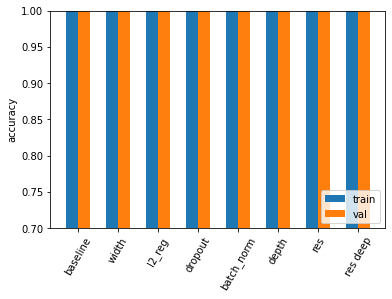

In [106]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width = 0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc)) + width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc)) + width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.show()